In [1]:
from functools import partial

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fairlearn.metrics import (
    MetricFrame,
    count,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
    plot_model_comparison,
    equal_opportunity_difference
)
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import DemographicParity, EqualizedOdds, ExponentiatedGradient
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from ucimlrepo import fetch_ucirepo

np.random.seed(436)

In [2]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 

# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# metadata 
print(adult.metadata) 

# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [3]:
# Unite X and y to do some operations before splitting the data
df = pd.concat([X, y], axis=1)

In [4]:
# Dataset Description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
# Count how many missing values in each column
print(df.isnull().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [6]:
# Remove nan values, as there are few nan values
df = df.dropna()

In [7]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
# Reduce size of dataset
df = df.astype({
    'age': 'int8',
    'hours-per-week': 'int8'
})

# Turn target column into binary
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [9]:
sensitive_features = [
    "age",
    "race",
    "sex",
    "native-country",
]

# Save sensitive features
#sensitive_df = df[sensitive_features]
#sensitive_df.to_csv("data/sensitive_features.csv", index=False)

In [10]:
# Remove some columns and save sensitive features
cols_to_remove = [
    #"fnlwgt",  # show how many people in the general population have the same characteristics as the sampled person
    "education-num",  # Already have education column
    "relationship",  # Not relevant to skills
    #"marital-status",  # Not relevant to skills
    #"race",  # Not relevant to skills
    #"sex",  # Not relevant to skills
    #"native-country",  # Not relevant to skills
    #"capital-gain",  # 91% are zeros
    #"capital-loss",  # 95% are zeros
]

df.drop(columns=cols_to_remove, inplace=True)

In [11]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Cuba,0


In [12]:
# Split the data
target = df["income"]
race = df["race"]
sex = df["sex"]
native_country = df["native-country"]
train_dataset, test_dataset, y_train, y_test, race_train, race_test, sex_train, sex_test, native_country_train, native_country_test = train_test_split(
    df, target, race, sex, native_country, test_size=0.3, random_state=436, stratify=target
)

x_train = train_dataset.drop(['income', 'race', 'sex', 'native-country'], axis=1)
x_test = test_dataset.drop(['income', 'race', 'sex', 'native-country'], axis=1)

In [13]:
race_train.value_counts()

race
White                 28544
Black                  3180
Asian-Pac-Islander     1027
Amer-Indian-Eskimo      315
Other                   268
Name: count, dtype: int64

In [14]:
# Save split data
# x_train.to_csv("data/x_train_all_columns.csv", index=False)
# x_test.to_csv("data/x_test_all_columns.csv", index=False)
# y_train.to_csv("data/y_train_all_columns.csv", index=False)
# y_test.to_csv("data/y_test_all_columns.csv", index=False)

In [15]:
numerical = ["age", "hours-per-week"]
categorical = x_train.columns.difference(numerical)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

transformations = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical)]
)

# Append SMOTE and classifier to preprocessing pipeline.
clf = ImbPipeline(
    steps=[
        ("preprocessor", transformations),
        ("smote", SMOTE(random_state=436)),
        ("classifier", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]
)
model = clf.fit(x_train, y_train)

In [16]:
# Evaluate the model
score = model.score(x_test, y_test)
print(f"Model Score: {score}")

Model Score: 0.8277455029047386


In [17]:
# Save the model
joblib.dump(model, "models/model_base.pkl")

['models/model_base.pkl']

# Fairness Evaluations

## Accuracy Parity

In [18]:
y_pred = model.predict(x_test)

# Sensitive features to evaluate
sensitive_features_list = ['race', 'sex', 'native-country']

# Evaluate and print metric frames for each sensitive feature
for feature in sensitive_features_list:
    mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=test_dataset[feature])
    print(f"Metric Frame for {feature.capitalize()}:")
    print(f"Overall Accuracy: {mf.overall.item()}")
    print(f"Accuracy by {feature.capitalize()}:")
    display(mf.by_group)
    print("\n")
    print(15 * "---")

Metric Frame for Race:
Overall Accuracy: 0.8277455029047386
Accuracy by Race:


race
Amer-Indian-Eskimo    0.896552
Asian-Pac-Islander    0.738095
Black                 0.907749
Other                 0.888000
White                 0.820536
Name: accuracy_score, dtype: float64



---------------------------------------------
Metric Frame for Sex:
Overall Accuracy: 0.8277455029047386
Accuracy by Sex:


sex
Female    0.926345
Male      0.779652
Name: accuracy_score, dtype: float64



---------------------------------------------
Metric Frame for Native-country:
Overall Accuracy: 0.8277455029047386
Accuracy by Native-country:


native-country
?                             0.776536
Cambodia                      0.600000
Canada                        0.810345
China                         0.777778
Columbia                      0.958333
Cuba                          0.857143
Dominican-Republic            0.954545
Ecuador                       0.866667
El-Salvador                   0.977273
England                       0.868421
France                        0.818182
Germany                       0.764706
Greece                        0.705882
Guatemala                     1.000000
Haiti                         0.888889
Holand-Netherlands            1.000000
Honduras                      1.000000
Hong                          0.875000
Hungary                       0.833333
India                         0.588235
Iran                          0.863636
Ireland                       0.875000
Italy                         0.650000
Jamaica                       0.758621
Japan                         0.666667
Laos      



---------------------------------------------


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

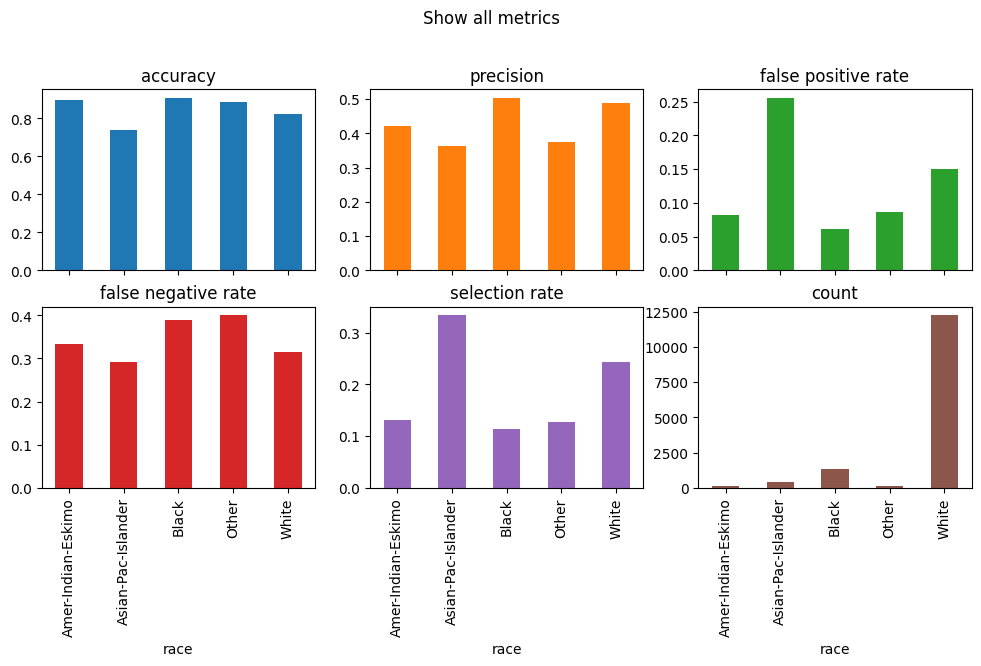

In [19]:
#demographic_parity_difference_partial = partial(demographic_parity_difference, sensitive_features=race_test, method="between_groups")

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
    #"demographic parity": demographic_parity_difference_partial,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=race_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [20]:
metric_frame.by_group

,accuracy,precision,false positive rate,false negative rate,selection rate,count
race,,,,,,
Amer-Indian-Eskimo,0.896552,0.421053,0.082707,0.333333,0.131034,145.0
Asian-Pac-Islander,0.738095,0.364286,0.255747,0.291667,0.333333,420.0
Black,0.907749,0.503268,0.061839,0.388889,0.112915,1355.0
Other,0.888000,0.375000,0.086957,0.400000,0.128000,125.0
White,0.820536,0.489112,0.150841,0.315197,0.243833,12242.0


In [21]:
test_dataset["race"].value_counts()

race
White                 12242
Black                  1355
Asian-Pac-Islander      420
Amer-Indian-Eskimo      145
Other                   125
Name: count, dtype: int64

In [22]:
metric_frame.difference()

accuracy                   0.169654
precision                  0.138982
false positive rate        0.193908
false negative rate        0.108333
selection rate             0.220418
count                  12117.000000
dtype: float64

In [23]:
print(f"difference: {metric_frame.difference().iloc[0]:.3}")
print(f"ratio: {metric_frame.ratio().iloc[0]:.3}")
print(f"max across groups: {metric_frame.group_max().iloc[0]:.3}")

difference: 0.17
ratio: 0.813
max across groups: 0.908


There are two allowed values for the method= parameter. The value between_groups computes the maximum difference between any two pairs of groups in the by_group property (i.e. group_max() - group_min()). Alternatively, to_overall computes the difference between each subgroup and the corresponding value from overall (if there are control features, then overall is multivalued for each metric). The result is the absolute maximum of these values.

In [24]:
# Demographic Parity
print("Demographic Parity Difference")
print(demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=race_test, method="between_groups"))

print("Demographic Parity Ratio")
print(demographic_parity_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=race_test, method="between_groups"))

Demographic Parity Difference
0.2204182041820418
Demographic Parity Ratio
0.33874538745387456


In [25]:
# Equalized Odds
print("Equalized Odds Difference")
print(equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=race_test, method="between_groups"))

print("Equalized Odds Ratio")
print(equalized_odds_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=race_test, method="between_groups"))

Equalized Odds Difference
0.19390823302750576
Equalized Odds Ratio
0.24179702142053922


# In-Processing 
## Reduction Mitigation

In [26]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

# 1. Combine training data with sensitive feature
x_train_with_sensitive = x_train.copy()
x_train_with_sensitive['race'] = race_train.reset_index(drop=True)

# 2. Define numerical and categorical features (including 'race' as categorical)
numerical = ["age", "hours-per-week"]
categorical = x_train_with_sensitive.columns.difference(numerical)

# 3. Encode categorical variables using LabelEncoder (for simplicity)
encoders = {}
for col in categorical:
    le = LabelEncoder()
    x_train_with_sensitive[col] = le.fit_transform(x_train_with_sensitive[col])
    encoders[col] = le  # Save the encoder for each column

# 4. Identify indices of categorical features (required for SMOTENC)
categorical_indices = [x_train_with_sensitive.columns.get_loc(c) for c in categorical]

# 5. Apply SMOTENC to the combined data
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=436)
x_resampled, y_resampled = smotenc.fit_resample(x_train_with_sensitive, y_train)

# 6. Extract 'race' after resampling
race_resampled = x_resampled['race']

# Save the resampled data
x_resampled.to_csv("data/x_resampled.csv", index=False)
y_resampled.to_csv("data/y_resampled.csv", index=False)

# 7. Remove 'race' from features
x_resampled = x_resampled.drop(columns=['race'])


# 8. Define the classifier pipeline (include any preprocessing if necessary)
clf_mitigation = Pipeline(
    steps=[
        ("classifier", LogisticRegression(max_iter=10000, class_weight='balanced')),
    ]
)

# 9. Fit the ExponentiatedGradient estimator
exponentiated_gradient_dp = ExponentiatedGradient(
    estimator=clf_mitigation,
    constraints=DemographicParity(),
    sample_weight_name="classifier__sample_weight",
)

exponentiated_gradient_eo = ExponentiatedGradient(
    estimator=clf_mitigation,
    constraints=EqualizedOdds(),
    sample_weight_name="classifier__sample_weight",
)

In [27]:
exponentiated_gradient_dp.fit(
    x_resampled,
    y_resampled,
    sensitive_features=race_resampled,
)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x00000244ACDF7020>,
                      estimator=Pipeline(steps=[('classifier',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000))]),
                      nu=np.float64(0.0009991860925214664),
                      sample_weight_name='classifier__sample_weight')

In [28]:
# Save the model
joblib.dump(exponentiated_gradient_dp, "models/exponentiated_gradient_dp.pkl")

['models/exponentiated_gradient_dp.pkl']

In [29]:
exponentiated_gradient_eo.fit(
    x_resampled,
    y_resampled,
    sensitive_features=race_resampled,
)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x00000244ACDC90D0>,
                      estimator=Pipeline(steps=[('classifier',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000))]),
                      nu=np.float64(0.0009992396977060375),
                      sample_weight_name='classifier__sample_weight')

In [30]:
# Save the model
joblib.dump(exponentiated_gradient_eo, "models/exponentiated_gradient_eo.pkl")

['models/exponentiated_gradient_eo.pkl']

In [31]:
# Prepare x_test by encoding using saved encoders
x_test_encoded = x_test.copy()
x_test_encoded['race'] = race_test.reset_index(drop=True)

# Apply the saved encoders to x_test
for col in categorical:
    le = encoders[col]
    # Handle unseen categories
    x_test_encoded[col] = x_test_encoded[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le_classes = le.classes_.tolist()
    if '<unknown>' not in le_classes:
        le_classes.append('<unknown>')
        le.classes_ = np.array(le_classes)
    x_test_encoded[col] = le.transform(x_test_encoded[col])

# Ensure that 'race' is not in x_test_encoded
if 'race' in x_test_encoded.columns:
    x_test_encoded = x_test_encoded.drop(columns=['race'])

In [32]:
y_pred_reduc_dp = exponentiated_gradient_dp.predict(x_test_encoded)
y_pred_reduc_eo = exponentiated_gradient_eo.predict(x_test_encoded)

In [33]:
# # Sensitive features to evaluate
# sensitive_features_list = ['race', 'sex', 'native-country']

# # Evaluate and print metric frames for each sensitive feature
# for feature in sensitive_features_list:
#     mf = MetricFrame(
#         metrics=accuracy_score,
#         y_true=y_test,
#         y_pred=y_pred_reduc,
#         sensitive_features=test_dataset[feature],
#     )
#     print(f"Metric Frame for {feature.capitalize()}:")
#     print(f"Overall Accuracy: {mf.overall.item()}")
#     print(f"Accuracy by {feature.capitalize()}:")
#     display(mf.by_group)
#     print("\n")
#     print(15 * "---")

array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

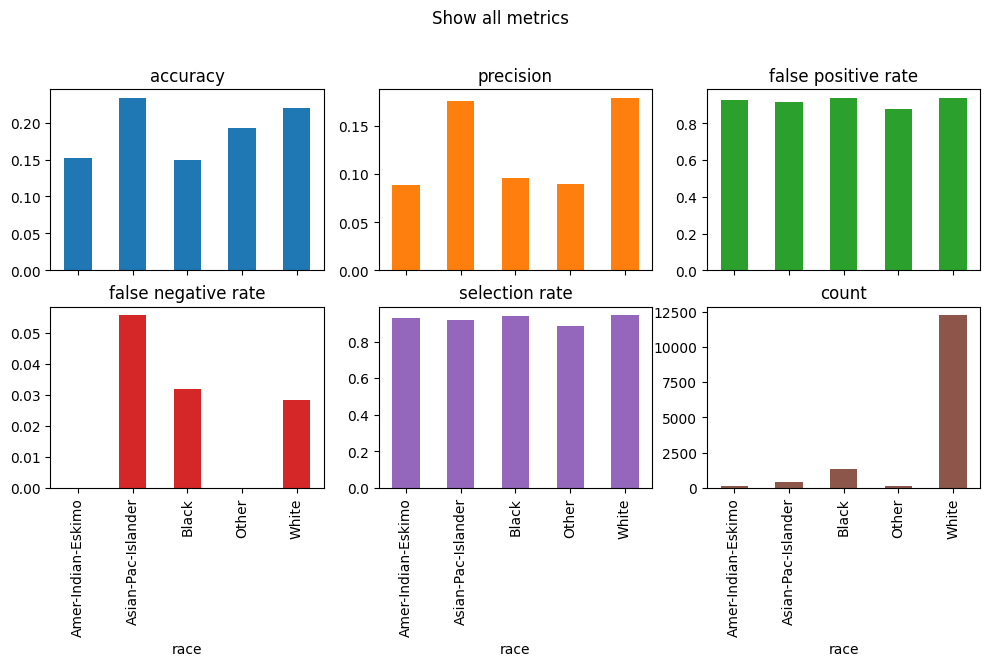

In [34]:
#demographic_parity_difference_partial = partial(demographic_parity_difference, sensitive_features=race_test, method="between_groups")

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
    #"demographic parity": demographic_parity_difference_partial,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred_reduc_dp, sensitive_features=race_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

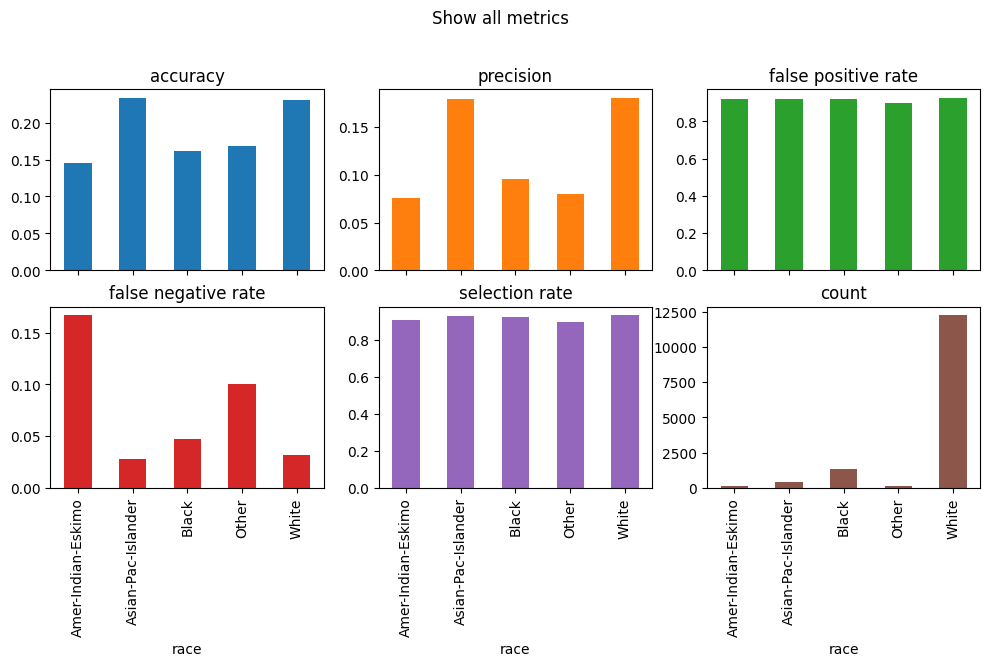

In [35]:
#demographic_parity_difference_partial = partial(demographic_parity_difference, sensitive_features=race_test, method="between_groups")

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
    #"demographic parity": demographic_parity_difference_partial,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred_reduc_eo, sensitive_features=race_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Different bounds for EqualizedOdds

No matplotlib.Axes object was provided to draw on, so we create a new one


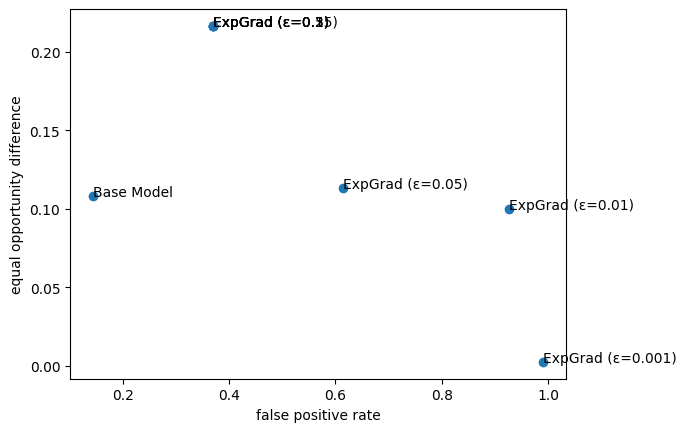

<Axes: xlabel='false positive rate', ylabel='equal opportunity difference'>

In [41]:
# Create a list of ExponentiatedGradient models with different epsilons for Equalized Odds and avaliate on false positive rate
epsilons = [0.001, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5]
exp_grad_models = {}

for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=clf_mitigation,
        constraints=EqualizedOdds(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(x_resampled, y_resampled, sensitive_features=race_resampled) #variable assignment only there to prevent large output
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(x_test_encoded)

# Add the base model predictions
exp_grad_models["Base Model"] = y_pred

# Plot the comparison
plot_model_comparison(
    x_axis_metric=false_positive_rate,
    y_axis_metric=equal_opportunity_difference,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=race_test,
    show_plot=True,
    point_labels =True)

No matplotlib.Axes object was provided to draw on, so we create a new one


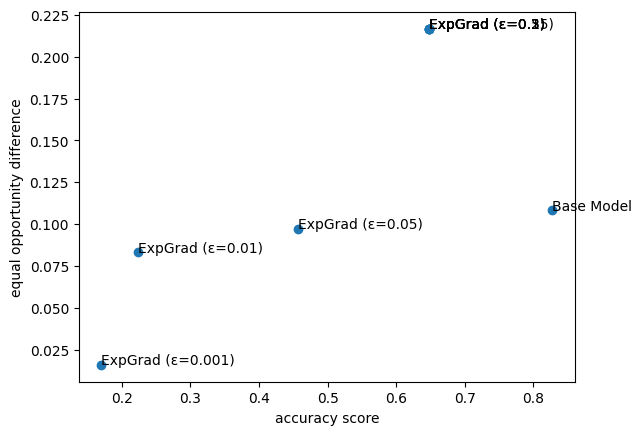

<Axes: xlabel='accuracy score', ylabel='equal opportunity difference'>

In [42]:
# Create a list of ExponentiatedGradient models with different epsilons for Equalized Odds and avaliate on accuracy
epsilons = [0.001, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5]
exp_grad_models = {}

for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=clf_mitigation,
        constraints=EqualizedOdds(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(x_resampled, y_resampled, sensitive_features=race_resampled) #variable assignment only there to prevent large output
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(x_test_encoded)

# Add the base model predictions
exp_grad_models["Base Model"] = y_pred

# Plot the comparison
plot_model_comparison(
    x_axis_metric=accuracy_score,
    y_axis_metric=equal_opportunity_difference,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=race_test,
    show_plot=True,
    point_labels =True)

# Different bounds for DemographicParity

No matplotlib.Axes object was provided to draw on, so we create a new one


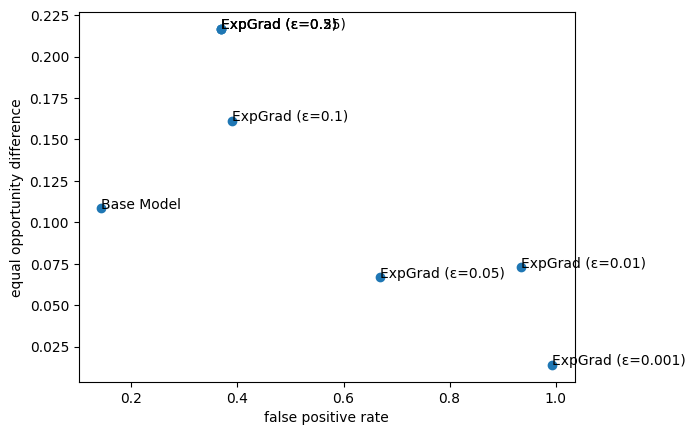

<Axes: xlabel='false positive rate', ylabel='equal opportunity difference'>

In [43]:
# Create a list of ExponentiatedGradient models with different epsilons for Demographic Parity and avaliate on false positive rate
epsilons = [0.001, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5]
exp_grad_models = {}

for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=clf_mitigation,
        constraints=DemographicParity(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(x_resampled, y_resampled, sensitive_features=race_resampled) #variable assignment only there to prevent large output
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(x_test_encoded)

# Add the base model predictions
exp_grad_models["Base Model"] = y_pred

# Plot the comparison
plot_model_comparison(
    x_axis_metric=false_positive_rate,
    y_axis_metric=equal_opportunity_difference,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=race_test,
    show_plot=True,
    point_labels =True)

No matplotlib.Axes object was provided to draw on, so we create a new one


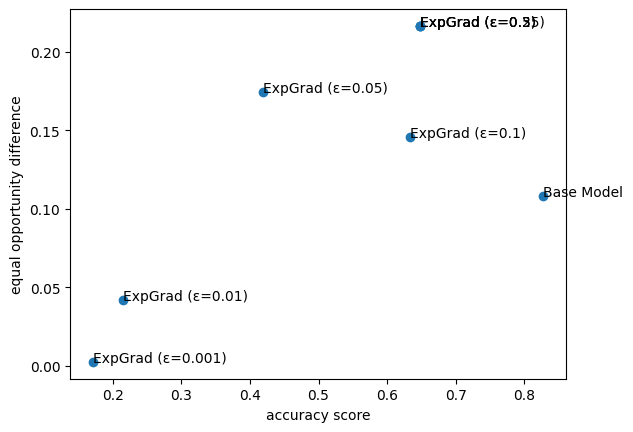

<Axes: xlabel='accuracy score', ylabel='equal opportunity difference'>

In [44]:
# Create a list of ExponentiatedGradient models with different epsilons for Demographic Parity and avaliate on accuracy
epsilons = [0.001, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5]
exp_grad_models = {}

for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=clf_mitigation,
        constraints=DemographicParity(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(x_resampled, y_resampled, sensitive_features=race_resampled) #variable assignment only there to prevent large output
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(x_test_encoded)

# Add the base model predictions
exp_grad_models["Base Model"] = y_pred

# Plot the comparison
plot_model_comparison(
    x_axis_metric=accuracy_score,
    y_axis_metric=equal_opportunity_difference,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=race_test,
    show_plot=True,
    point_labels =True)

[0 1 0 ... 0 0 0]
{
    "Amer-Indian-Eskimo": {
        "p0": 0.4208,
        "operation0": "[>0.6254605813480582]",
        "p1": 0.5791999999999999,
        "operation1": "[>0.32819565127908157]"
    },
    "Asian-Pac-Islander": {
        "p0": 0.33409523809523817,
        "operation0": "[>0.7808099639297994]",
        "p1": 0.6659047619047618,
        "operation1": "[>0.7118990804817362]"
    },
    "Black": {
        "p0": 0.8395454545454544,
        "operation0": "[>0.35694753441411714]",
        "p1": 0.16045454545454563,
        "operation1": "[>0.31431383297090876]"
    },
    "Other": {
        "p0": 0.08884210526315786,
        "operation0": "[>0.4983156018461625]",
        "p1": 0.9111578947368422,
        "operation1": "[>0.36728333879198594]"
    },
    "White": {
        "p0": 0.016853333333333272,
        "operation0": "[>0.7471929275139961]",
        "p1": 0.9831466666666667,
        "operation1": "[>0.699762622023367]"
    }
}


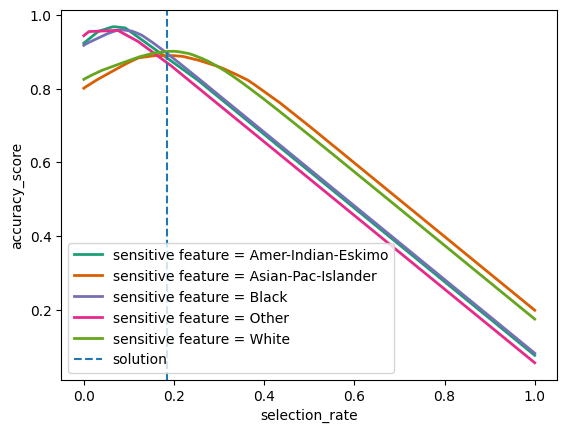

In [ ]:
import json
threshold_optimizer = ThresholdOptimizer(
    estimator=clf,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=False,
)
threshold_optimizer.fit(train_dataset, y_train, sensitive_features=race_train)
print(threshold_optimizer.predict(test_dataset, sensitive_features=race_test))
print(
    json.dumps(
        threshold_optimizer.interpolated_thresholder_.interpolation_dict,
        default=str,
        indent=4,
    )
)
plot_threshold_optimizer(threshold_optimizer)